# [Captum](https://captum.ai/)
Captum helps you understand how the data features impact the model predicitons.

We will use a built in image classifier in PyTorch. Captum can reveal which parts of an image support the model predicitions.

In [2]:
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

model = torchvision.models.resnet18(pretrained=True).eval()

response = requests.get(
    "https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")
img = Image.open(BytesIO(response.content))

center_crop = transforms.Compose(
    [transforms.Resize(256), transforms.CenterCrop(224)])

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

input_img=normalize(center_crop(img)).unsqueeze(0)

## Computing Attribution
Dog and Cat (class 208 and 283 respectively) are among the top predictions for the above image. Lets attribute each of these to the corresponding part of the input. We will use `occlusion` for this but many other algorithms are provided.

In [3]:
from captum.attr import Occlusion

occlusion = Occlusion(model)


strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
target=208,                       # Labrador index in ImageNet
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_dog = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)


target=283,                       # Persian cat index in ImageNet
attribution_cat = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=0)

## Visualising the Results
Using Captum's `visualization` utility

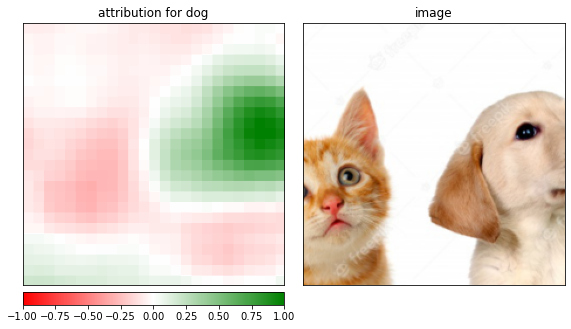

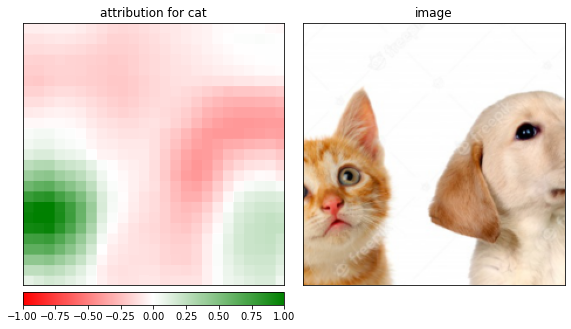

In [4]:
import numpy as np
from captum.attr import visualization as viz

# Convert the compute attribution tensor into an image-like numpy array
attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for dog", "image"],
                                      show_colorbar = True
                                     )


attribution_cat = np.transpose(attribution_cat.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cat,
                                      np.array(center_crop(img)),
                                      ["heat_map", "original_image"],
                                      ["all", "all"], # positive/negative attribution or all
                                      ["attribution for cat", "image"],
                                      show_colorbar = True
                                     )